In [5]:
import pickle
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

def load_cifar_batch(filename):
    """ 从单个 CIFAR 数据文件加载一个批次的数据 """
    with open(filename, 'rb') as f:
        data_dict = pickle.load(f, encoding='latin1')
        X = data_dict['data']
        Y = data_dict['labels']
        X = X.reshape(10000, 3, 32, 32).astype("float")
        Y = np.array(Y)
        return X, Y

def load_cifar10(data_dir):
    """ 从所有 CIFAR 文件加载整个数据集 """
    xs = []
    ys = []
    for batch in range(1, 6):
        f = os.path.join(data_dir, f'data_batch_{batch}')
        X, Y = load_cifar_batch(f)
        xs.append(X)
        ys.append(Y)
    X_train = np.concatenate(xs)
    Y_train = np.concatenate(ys)
    X_test, Y_test = load_cifar_batch(os.path.join(data_dir, 'test_batch'))
    return X_train, Y_train, X_test, Y_test

# 指定数据集路径
data_dir = "/Users/oliviagarbo/Documents/Deep learning/assignment 2/cifar-10-batches-py"

# 加载数据
X_train, Y_train, X_test, Y_test = load_cifar10(data_dir)

# 打印数据形状以验证加载成功
print("训练集图像数据形状:", X_train.shape)
print("训练集标签数据形状:", Y_train.shape)
print("测试集图像数据形状:", X_test.shape)
print("测试集标签数据形状:", Y_test.shape)


训练集图像数据形状: (50000, 3, 32, 32)
训练集标签数据形状: (50000,)
测试集图像数据形状: (10000, 3, 32, 32)
测试集标签数据形状: (10000,)


Epoch 1/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 1543s 4s/step - accuracy: 0.4251 - loss: 1.6845 - val_accuracy: 0.3170 - val_loss: 1.9859
Epoch 2/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 1525s 4s/step - accuracy: 0.7083 - loss: 0.8251 - val_accuracy: 0.6539 - val_loss: 1.0745
Epoch 3/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 1524s 4s/step - accuracy: 0.8004 - loss: 0.5737 - val_accuracy: 0.6183 - val_loss: 1.2065
Epoch 4/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 1528s 4s/step - accuracy: 0.8509 - loss: 0.4270 - val_accuracy: 0.7119 - val_loss: 0.8834
Epoch 5/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 1525s 4s/step - accuracy: 0.8873 - loss: 0.3260 - val_accuracy: 0.7662 - val_loss: 0.7543
Epoch 6/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 1528s 4s/step - accuracy: 0.9178 - loss: 0.2370 - val_accuracy: 0.7274 - val_loss: 1.0927
Epoch 7/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 1526s 4s/step - accuracy: 0.9405 - loss: 0.1729 - val_accuracy: 0.7546 - val_loss: 0.9861
Epoch 8/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 1631s 4s/step - accuracy: 0.9554 - loss: 0.1257 - 

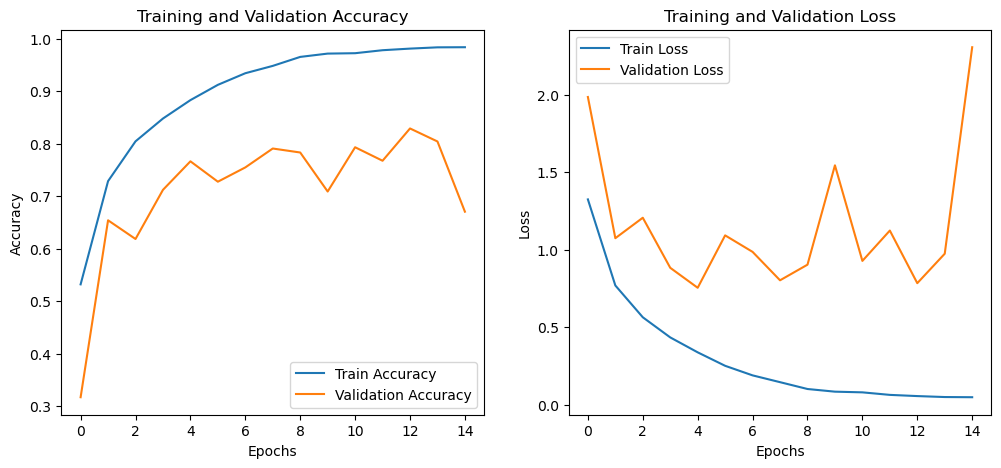

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 构建残差块
def residual_block(x, filters, stride=1):
    shortcut = x
    x = Conv2D(filters, (3, 3), strides=stride, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters, (3, 3), strides=1, padding="same")(x)
    x = BatchNormalization()(x)

    if stride != 1:
        shortcut = Conv2D(filters, (1, 1), strides=stride)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    return x

# 构建 ResNet-18
def build_resnet18(input_shape=(32, 32, 3), num_classes=10):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), strides=1, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = residual_block(x, 64, stride=1)
    x = residual_block(x, 64, stride=1)
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128, stride=1)
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256, stride=1)
    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512, stride=1)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

# 假设之前已使用 load_cifar10() 加载数据
# 数据预处理：将通道维度移到最后
X_train = X_train.transpose(0, 2, 3, 1) / 255.0
X_test = X_test.transpose(0, 2, 3, 1) / 255.0
Y_train = tf.keras.utils.to_categorical(Y_train, 10)
Y_test = tf.keras.utils.to_categorical(Y_test, 10)

# 创建 ResNet-18 模型
model = build_resnet18()

# 编译模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 设置 EarlyStopping 回调
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 训练模型
history = model.fit(X_train, Y_train, epochs=80, batch_size=128, validation_data=(X_test, Y_test), callbacks=[early_stop])

# 绘制准确率和损失曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


196/196 ━━━━━━━━━━━━━━━━━━━━ 409s 2s/step - accuracy: 0.3598 - loss: 2.7122 - val_accuracy: 0.1009 - val_loss: 3.6616
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - accuracy: 0.5750 - loss: 1.7367 - val_accuracy: 0.3134 - val_loss: 2.5529
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - accuracy: 0.6323 - loss: 1.4015 - val_accuracy: 0.3595 - val_loss: 2.7653
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 396s 2s/step - accuracy: 0.6791 - loss: 1.2187 - val_accuracy: 0.4226 - val_loss: 2.0606
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.7056 - loss: 1.1252 - val_accuracy: 0.4006 - val_loss: 2.3904
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.7356 - loss: 1.0361 - val_accuracy: 0.4122 - val_loss: 2.3934
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.7501 - loss: 0.9853 - val_accuracy: 0.5188 - val_loss: 1.8945
Epoch 8/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 547s 3s/step - accuracy: 0.7684 - loss: 0.9347 - val_accuracy: 0.470

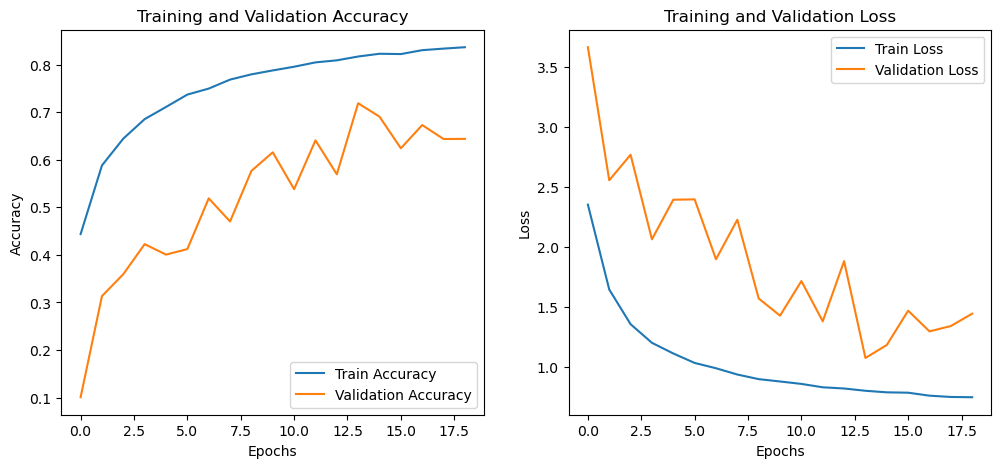

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# 构建简化的残差块
def residual_block(x, filters, stride=1):
    shortcut = x
    x = Conv2D(filters, (3, 3), strides=stride, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters, (3, 3), strides=1, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)

    if stride != 1:
        shortcut = Conv2D(filters, (1, 1), strides=stride, kernel_regularizer=tf.keras.regularizers.l2(0.001))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    return x

# 构建简化的 ResNet 模型
def build_simple_resnet(input_shape=(32, 32, 3), num_classes=10):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), strides=1, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # 减少残差块数量
    x = residual_block(x, 64, stride=1)
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 256, stride=2)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # 加入 Dropout 防止过拟合
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

# 假设之前已使用 load_cifar10() 加载数据
# 数据预处理：将通道维度移到最后
X_train = X_train.transpose(0, 2, 3, 1) / 255.0
X_test = X_test.transpose(0, 2, 3, 1) / 255.0
Y_train = tf.keras.utils.to_categorical(Y_train, 10)
Y_test = tf.keras.utils.to_categorical(Y_test, 10)

# 数据增强
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# 创建简化的 ResNet 模型
model = build_simple_resnet()

# 编译模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 设置 EarlyStopping 回调
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型，减少 epochs 数和增大 batch_size
history = model.fit(datagen.flow(X_train, Y_train, batch_size=256), 
                    epochs=20, 
                    validation_data=(X_test, Y_test), 
                    callbacks=[early_stop])

# 绘制准确率和损失曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 517s 1s/step - accuracy: 0.3047 - loss: 2.9864 - val_accuracy: 0.1442 - val_loss: 4.1240 - learning_rate: 1.0000e-04
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 453s 1s/step - accuracy: 0.4784 - loss: 2.3765 - val_accuracy: 0.5448 - val_loss: 2.1540 - learning_rate: 1.0000e-04
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 574s 1s/step - accuracy: 0.5400 - loss: 2.1414 - val_accuracy: 0.5514 - val_loss: 2.1047 - learning_rate: 1.0000e-04
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 574s 1s/step - accuracy: 0.5837 - loss: 1.9674 - val_accuracy: 0.5560 - val_loss: 2.0209 - learning_rate: 1.0000e-04
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 571s 1s/step - accuracy: 0.6169 - loss: 1.8233 - val_accuracy: 0.6582 - val_loss: 1.6897 - learning_rate: 1.0000e-04
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 574s 1s/step - accuracy: 0.6370 - loss: 1.7128 - val_accuracy: 0.6681 - val_loss: 1.6168 - learning_rate: 1.0000e-04
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 571s 1s/step - acc

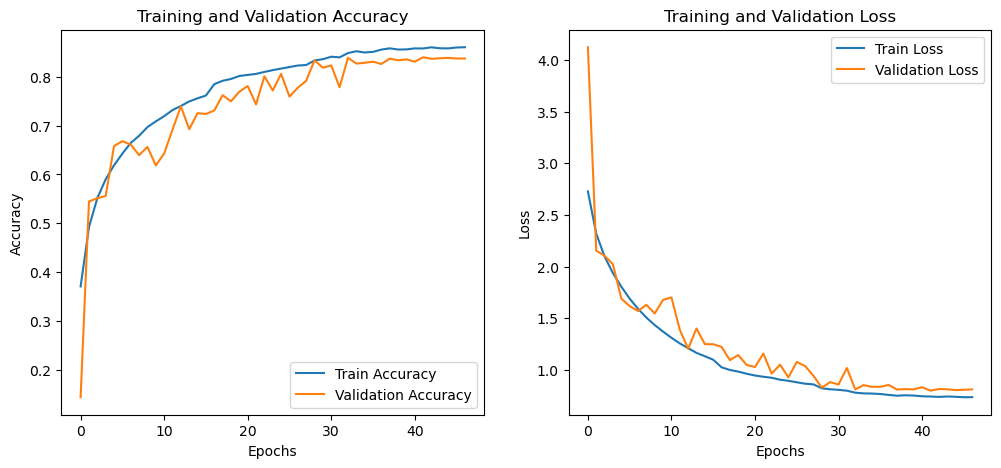

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

# 构建简化的残差块
def residual_block(x, filters, stride=1):
    shortcut = x
    x = Conv2D(filters, (3, 3), strides=stride, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters, (3, 3), strides=1, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)

    if stride != 1:
        shortcut = Conv2D(filters, (1, 1), strides=stride, kernel_regularizer=tf.keras.regularizers.l2(0.001))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    return x

# 构建简化的 ResNet 模型
def build_simple_resnet(input_shape=(32, 32, 3), num_classes=10):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), strides=1, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # 增加残差块数量
    for filters in [64, 128, 256]:
        x = residual_block(x, filters, stride=2 if filters != 64 else 1)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)  # 增加 Dropout 防止过拟合
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

# 加载 CIFAR-10 数据集
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

# 数据预处理：归一化并将标签进行 one-hot 编码
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0
Y_train = tf.keras.utils.to_categorical(Y_train, 10)
Y_test = tf.keras.utils.to_categorical(Y_test, 10)

# 数据增强
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1
)
datagen.fit(X_train)

# 创建简化的 ResNet 模型
model = build_simple_resnet()

# 编译模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 设置 EarlyStopping 和 ReduceLROnPlateau 回调
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# 训练模型
history = model.fit(datagen.flow(X_train, Y_train, batch_size=128), 
                    epochs=50, 
                    validation_data=(X_test, Y_test), 
                    callbacks=[early_stop, reduce_lr]
                    
                   )

# 绘制准确率和损失曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()
